In [40]:
!pip install xgboost

In [41]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split

In [42]:
car = pd.read_csv('Cars-dataset.csv',sep=',')

In [43]:
data = car.copy()

In [44]:
data.shape

(418, 9)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          418 non-null    int64  
 1   Gender       418 non-null    object 
 2   Engineer     418 non-null    int64  
 3   MBA          418 non-null    int64  
 4   Work Exp     418 non-null    int64  
 5   Salary       418 non-null    float64
 6   Distance     418 non-null    float64
 7   license      418 non-null    int64  
 8   Opt_service  418 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 29.5+ KB


In [46]:
data.head()

,Age,Gender,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
0,28,Male,1,0,5,14.4,5.1,0,0
1,24,Male,1,0,6,10.6,6.1,0,0
2,27,Female,1,0,9,15.5,6.1,0,0
3,25,Male,0,0,1,7.6,6.3,0,0
4,25,Female,0,0,3,9.6,6.7,0,0


In [47]:
data[['Age','Work Exp','Salary','Distance']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,418.0,27.334928,4.153272,18.0,25.000,27.0,29.000,43.0
Work Exp,418.0,5.873206,4.816110,0.0,3.000,5.0,8.000,24.0
Salary,418.0,15.418421,9.660234,6.5,9.625,13.0,14.900,57.0
Distance,418.0,11.306220,3.722143,3.2,8.600,10.9,13.575,23.4


In [48]:
cat_cols=['Engineer','MBA','Work Exp','license','Opt_service']

for column in cat_cols:
    print(data[column].value_counts())
    print('-'*30)

1    313
0    105
Name: Engineer, dtype: int64
------------------------------
0    309
1    109
Name: MBA, dtype: int64
------------------------------
4     53
2     47
3     46
6     45
5     42
0     29
8     28
7     27
1     22
9     17
10    12
11     7
14     7
19     6
20     6
16     5
21     4
12     4
18     3
22     3
13     2
17     1
15     1
24     1
Name: Work Exp, dtype: int64
------------------------------
0    332
1     86
Name: license, dtype: int64
------------------------------
0    383
1     35
Name: Opt_service, dtype: int64
------------------------------


In [49]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

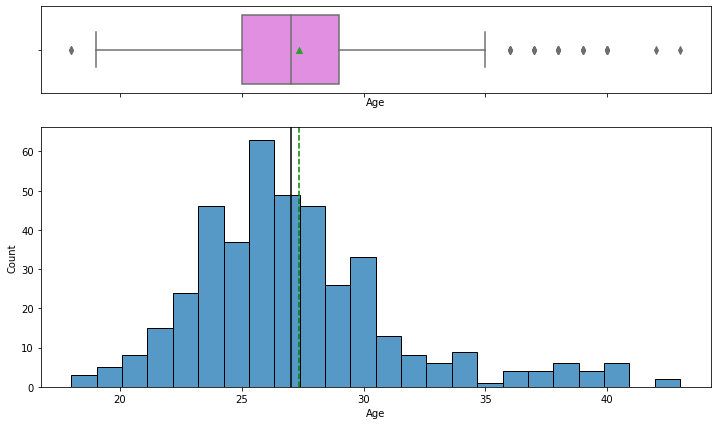

In [50]:
histogram_boxplot(data,'Age')

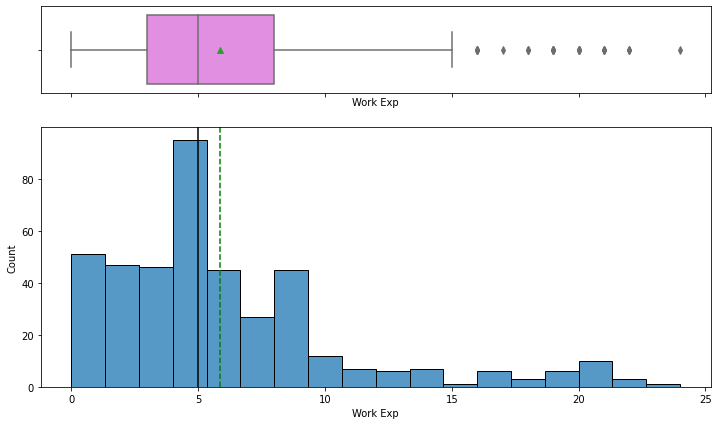

In [51]:
histogram_boxplot(data,'Work Exp')

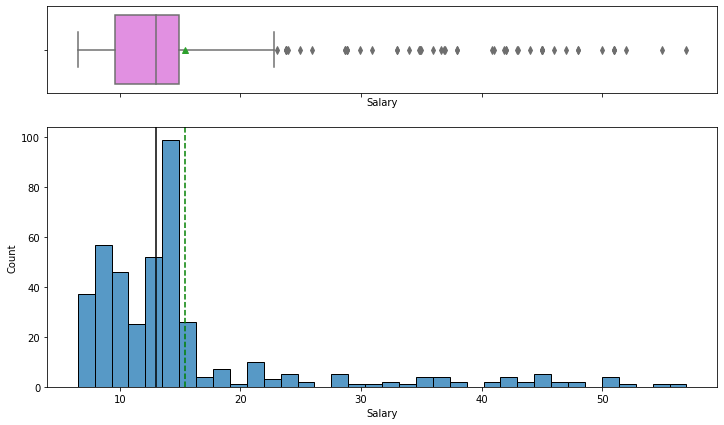

In [52]:
histogram_boxplot(data,'Salary')

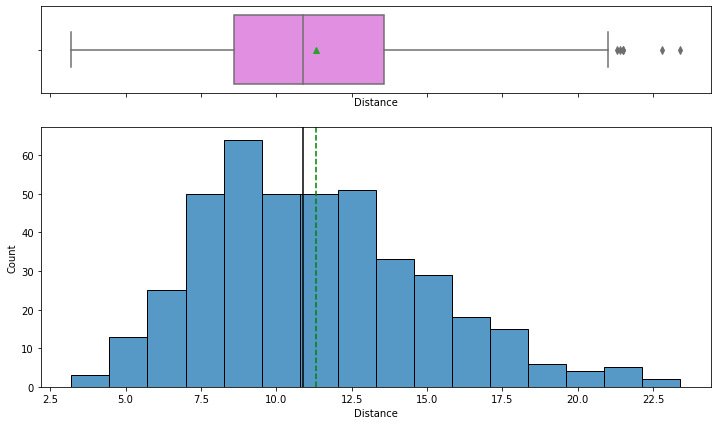

In [53]:
histogram_boxplot(data, 'Distance')

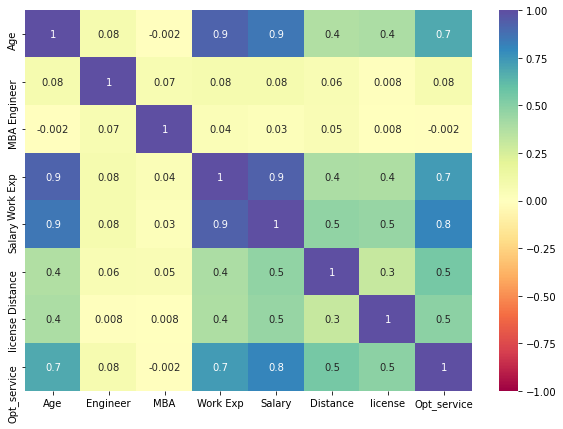

In [63]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

In [66]:
data.corr()

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service
Age,1.000000,0.082666,-0.001980,0.924430,0.857784,0.377019,0.391177,0.683498
Engineer,0.082666,1.000000,0.067597,0.079911,0.079428,0.060616,0.008227,0.075514
MBA,-0.001980,0.067597,1.000000,0.039443,0.028627,0.051624,0.007739,-0.002494
Work Exp,0.924430,0.079911,0.039443,1.000000,0.931810,0.395161,0.389882,0.731563
Salary,0.857784,0.079428,0.028627,0.931810,1.000000,0.475367,0.457207,0.810703
Distance,0.377019,0.060616,0.051624,0.395161,0.475367,1.000000,0.309882,0.548475
license,0.391177,0.008227,0.007739,0.389882,0.457207,0.309882,1.000000,0.487126
Opt_service,0.683498,0.075514,-0.002494,0.731563,0.810703,0.548475,0.487126,1.000000


In [65]:
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

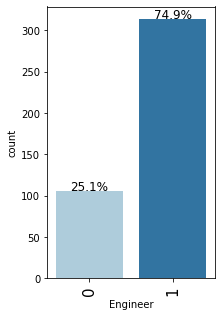

In [56]:
labeled_barplot(data,'Engineer',perc=True)

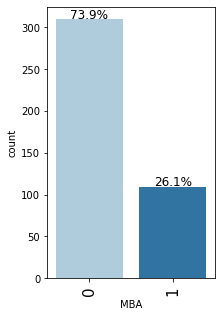

In [57]:
labeled_barplot(data,'MBA',perc=True)

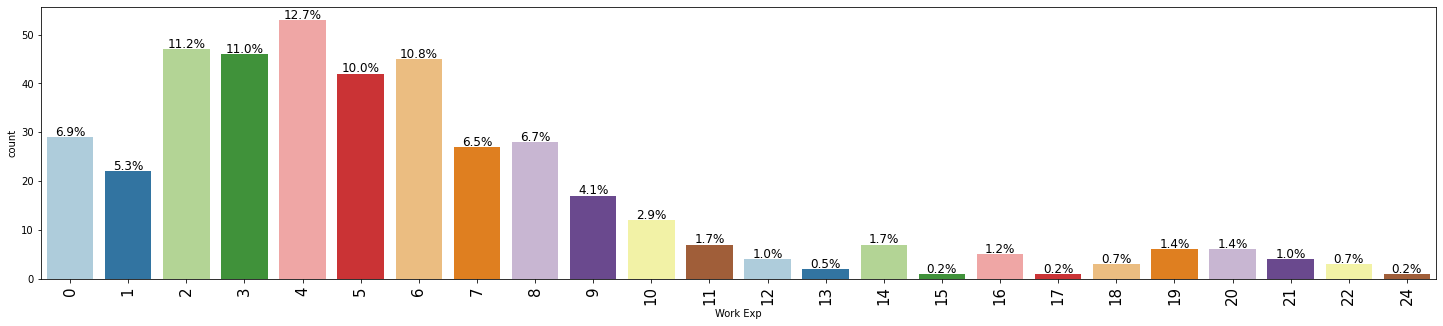

In [58]:
labeled_barplot(data,'Work Exp',perc=True)

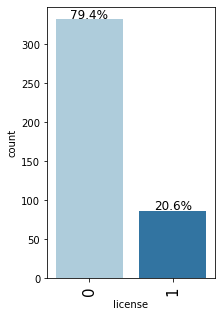

In [59]:
labeled_barplot(data,'license',perc=True)

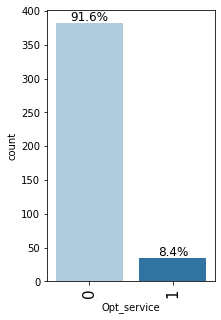

In [60]:
labeled_barplot(data,'Opt_service',perc=True)

In [68]:
dummy_data = pd.get_dummies(
    data,
    columns=[
        "Gender"
    ]
)
dummy_data.head()

,Age,Engineer,MBA,Work Exp,Salary,Distance,license,Opt_service,Gender_Female,Gender_Male
0,28,1,0,5,14.4,5.1,0,0,0,1
1,24,1,0,6,10.6,6.1,0,0,0,1
2,27,1,0,9,15.5,6.1,0,0,1,0
3,25,0,0,1,7.6,6.3,0,0,0,1
4,25,0,0,3,9.6,6.7,0,0,1,0


In [73]:
#X = data.drop('Gender', axis=1)
#y = data['Gender']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [75]:
X_train.shape, X_test.shape

((292, 8), (126, 8))

In [76]:
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Percentage of classes in training set:
Male      0.702055
Female    0.297945
Name: Gender, dtype: float64
Percentage of classes in test set:
Male      0.730159
Female    0.269841
Name: Gender, dtype: float64


In [79]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [80]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [81]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

NameError: name 'DecisionTreeClassifier' is not defined

In [82]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

NotFittedError: All estimators failed to fit

In [ ]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)